In [8]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

# we load the FashionMNIST dataset
training_data = datasets.FER2013(
    root="data",
    split="train",
    transform=ToTensor()
)

test_data = datasets.FER2013(
    root="data",
    split="train",
    transform=ToTensor()
)

def img2vec(img):
    return torch.flatten(img, start_dim=2)

def vec2img(vec):
    return torch.unflatten(vec, -1, (48, 48))

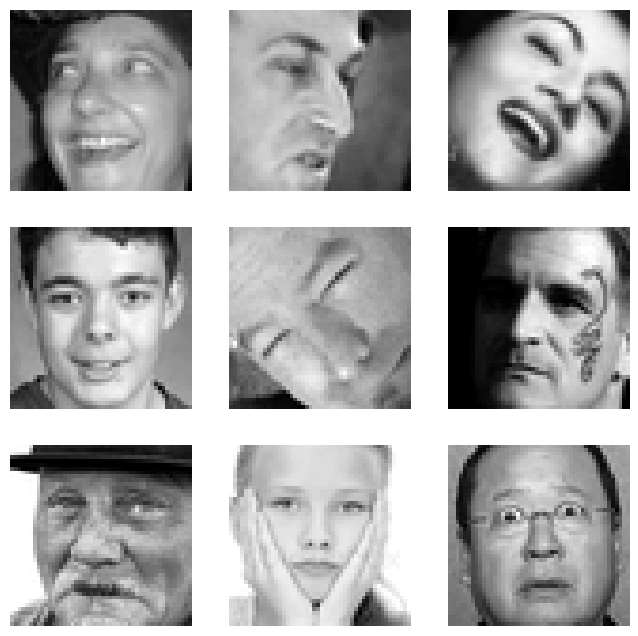

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Define model

In [10]:
from torch.nn import Module, ModuleList, Linear, Conv2d, ConvTranspose2d

class Encoder(Module):
    def __init__(self, channels, lat, device, kernel=3):
        super(Encoder, self).__init__()
        convs = []
        for c, c_next in zip(channels, channels[1:]):
            convs.append(Conv2d(c, c_next, kernel))

        self.convs = ModuleList(convs)

        self.mean = Linear(channels[-1] * ((48 - (kernel - 1) * (len(channels) - 1)) ** 2), lat)
        self.std = Linear(channels[-1] * ((48 - (kernel - 1) * (len(channels) - 1)) ** 2), lat)
        
    def forward(self, x):
        for conv in self.convs:
            x = torch.relu(conv(x))

        x = torch.flatten(x, start_dim=1)

        mu = self.mean(x)
        sigma = torch.exp(self.std(x))

        return mu, sigma

class Decoder(Module):
    def __init__(self, channels, lat, device, kernel=3):
        super(Decoder, self).__init__()
        self.channels = channels
        self.kernel = kernel
        self.l1 = Linear(lat, channels[-1] * ((48 - (kernel - 1) * (len(channels) - 1)) ** 2))

        convs = []
        channels = list(reversed(channels))
        for c, c_next in zip(channels, channels[1:]):
            convs.append(ConvTranspose2d(c, c_next, kernel))

        self.convs = ModuleList(convs)

    def forward(self, z):
        dim = 48 - (self.kernel - 1) * (len(self.channels) - 1)
        z = torch.relu(self.l1(z))
        z = torch.unflatten(z, 1, (self.channels[-1], dim, dim))

        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                z = torch.relu(conv(z))
            else:
                z = torch.sigmoid(conv(z))

        return z

class VAE(Module):
    def __init__(self, channels, lat, device, kernel=3):
        super(VAE, self).__init__()
        channels = [1] + channels
        self.encoder = Encoder(channels, lat, device, kernel=kernel)
        self.decoder = Decoder(channels, lat, device, kernel=kernel)
        self.img_loss = torch.tensor(0)
        self.device = device
        self.to(device)

    def reconstruct_loss(self, x, y):
        return -torch.sum(x * torch.log(y + 1e-9) + (1 - x) * torch.log(1 - y + 1e-9))
    
    def kl_loss(self, mu, sigma):
        return torch.sum(mu ** 2 + sigma ** 2 - torch.log(sigma) - 0.5)
    
    def gaussian(self, mu, sigma):
        return mu + sigma * torch.normal(0.0, 1.0, mu.shape, device=self.device)
        
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = self.gaussian(mu, sigma)
        y = self.decoder(z)

        self.img_loss = self.reconstruct_loss(x, y) + self.kl_loss(mu, sigma)

        return y
    
    def batch_loss(self):
        return torch.sum(self.img_loss)

    def backward(self):
        self.img_loss.backward()

Define training loop

In [11]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch.cuda.empty_cache()

channels = [2, 8, 64]
lat = 128
epochs = 15
batch_size = 128

training_data = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_data, batch_size=batch_size, shuffle=True)

batches = len(training_data)

vae = VAE(channels, lat, device)
adam = Adam(vae.parameters())

for e in range(epochs):
    loss = 0
    for x_batch, _ in tqdm(training_data):
        adam.zero_grad()
        vae.forward(x_batch.to(device))

        loss += vae.batch_loss()
        vae.backward()
        adam.step()

    print(f"Training loss [{e + 1}/{epochs}]: {loss / batches / batch_size:0.4f}")

100%|██████████| 225/225 [00:09<00:00, 23.39it/s]


Training loss [1/15]: 1661.0172


100%|██████████| 225/225 [00:09<00:00, 23.04it/s]


Training loss [2/15]: 1635.8939


100%|██████████| 225/225 [00:09<00:00, 23.22it/s]


Training loss [3/15]: 1633.0227


100%|██████████| 225/225 [00:09<00:00, 22.59it/s]


Training loss [4/15]: 1563.5946


100%|██████████| 225/225 [00:09<00:00, 22.59it/s]


Training loss [5/15]: 1461.2891


100%|██████████| 225/225 [00:09<00:00, 23.36it/s]


Training loss [6/15]: 1437.7736


100%|██████████| 225/225 [00:09<00:00, 23.37it/s]


Training loss [7/15]: 1426.7134


100%|██████████| 225/225 [00:09<00:00, 23.38it/s]


Training loss [8/15]: 1421.6759


100%|██████████| 225/225 [00:09<00:00, 23.35it/s]


Training loss [9/15]: 1418.6470


100%|██████████| 225/225 [00:09<00:00, 23.29it/s]


Training loss [10/15]: 1416.5846


100%|██████████| 225/225 [00:09<00:00, 23.26it/s]


Training loss [11/15]: 1414.8817


100%|██████████| 225/225 [00:09<00:00, 22.89it/s]


Training loss [12/15]: 1413.6418


100%|██████████| 225/225 [00:09<00:00, 23.28it/s]


Training loss [13/15]: 1412.7136


100%|██████████| 225/225 [00:09<00:00, 23.30it/s]


Training loss [14/15]: 1411.7560


100%|██████████| 225/225 [00:09<00:00, 23.31it/s]

Training loss [15/15]: 1411.0804


Evaluate on test set

In [12]:
total_loss = 0
batches = len(test_data)

with torch.no_grad():
    for x_batch, _ in test_data:
      vae.forward(x_batch.to(device))

      total_loss += vae.batch_loss()

print(f"Test loss: {total_loss / batches / batch_size:0.4f}")

Test loss: 1410.9460


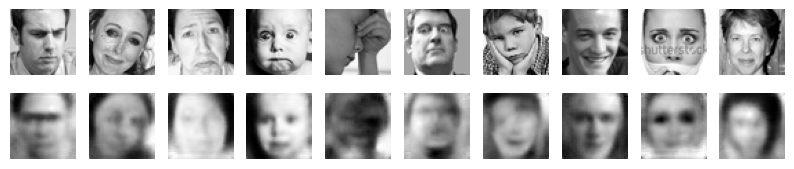

In [13]:
imgs = []
for test_batch, _ in test_data:
    for idx in range(batch_size):
        imgs.append(test_batch[idx])
        
        if len(imgs) == 10:
            break

    if len(imgs) == 10:
        break

cols, rows = 10, 2
figure = plt.figure(figsize=(cols, rows))
idx = 0
for i, img in zip(range(1, int(cols * rows / 2) + 1), imgs):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.detach().squeeze(), cmap="gray")

    idx += 1

idx = 0
for i, img in zip(range(int(cols * rows / 2) + 1, cols * rows + 1), imgs):
    with torch.no_grad():
        img = vae.forward(img[:, None, :, :].to(device))

    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.cpu().detach().squeeze(), cmap="gray")

    idx += 1

plt.show()

Sample from latent space distribution

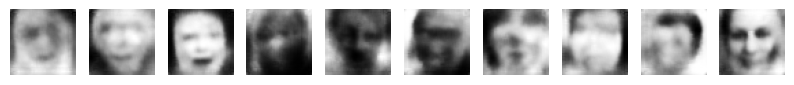

In [14]:
cols, rows = 10, 1
figure = plt.figure(figsize=(cols, rows))
for i in range(1, 10 + 1):
    img = vae.decoder(torch.normal(torch.zeros(lat), torch.ones(lat))[None, :].to(device))

    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.cpu().detach().squeeze(), cmap="gray")